In [1]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import spatial_efd
import math 
import signac
import numpy as np
import os.path

In [2]:
# Defining number of input parameters and number of outputs in the feature 
num_samples = 150
num_harmonics = 20
num_input_parameter = 35

#### Loading screening data data

In [3]:
""" This section of the code does the following tasks
1. Creating input and output training data for building surrogate models
2. The input data is stored in master_parameter_input array with shape [num_samples,num_parameters]
3. The output data is stored in master_parameter_output array with shape [num samples, 4 x num_harmonics]
"""
# Fetching project from signac workspace

# Checking if data exists
doesDataFileExist = os.path.isfile("master_feature_output.npy")

# Loading datafiles if they exist
# Else fetching and preparing data from signac workspace
if doesDataFileExist == True:
    # Loading input parameters
    master_parameter_input_n = np.load('master_parameter_input_n.npy', )
    # Loading output EFD coefficients
    master_feature_output = np.load('master_feature_output.npy', )
else:
    print("No data file exists!")


print(np.shape(master_parameter_input_n))
print(np.shape(master_feature_output))


(150, 35)
(150, 80)


##### Output data preprocessing - Feature reduction using PCA

In [4]:
""" A) his section of code proejects the feature space into lower dimensions using PCA
b) Scikit learn was first used to normalize the data and then take principal components
c) Varaince captured in the principal components is also estimated
d) Further the section plots the correlations between KECM and different principal components
"""
# Importing libraries
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Storing the feature output data in x
x = master_feature_output
# Normalizing the data
x = StandardScaler().fit_transform(x)
# Defining number of components in PCA
pca = PCA(n_components=8)
# Using scikit learn to calculate PCs
principalComponents = pca.fit_transform(x)
# Calculating weights
weights = pca.components_
# Variance explained in the principal components
print(pca.explained_variance_ratio_)


[0.21895301 0.17323367 0.11290526 0.09812456 0.08294328 0.05576723
 0.04099771 0.03003538]


#### Input data preprocesseing : Parameter selection and data normaization

In [5]:
""" TRSAINING AND TESTING DATA FOR GPR MODEL
    a) This section of the code prepares the training data for the GPR model.
    b) Parameter that were varied during the LHS rae chosen as the input variables to the model.
    c) Output training data are the PCs of the PCs of the EFD features
    d) A split is carried out in the inut and output data to create a training and testing dataset for model
    e) Definition of parameters varied in LHS
       i) param_2 - T_squamous_basal 
       ii) param_5 - T_cuboidal_basal
       iii) param_8 - T_columnar_basal
       iv) param_18 - k_columnar_basal
       v) param_19 - k_columnar_apical
       vi) param_20 - k_columnar_lateral
       vii) param_34 - k_ecm
"""

# Transforming input parameter data to log scale
master_parameter_input = np.log(master_parameter_input_n)
# Number of parameters in the Latin Hypercube sampling
num_parameters_LHS = 7
param_index = [1, 4, 7, 17, 18, 19, 33]
split_size = 110
pc_index_anal = 7
# Initializing the training data
train_x_numpy = np.zeros((num_samples, num_parameters_LHS))
# Getting the parameter values from master_parameter_input
for i in range(num_parameters_LHS):
    train_x_numpy[:,i] = master_parameter_input[:,param_index[i]]

# Normalizing the data around mean
train_x_numpy = StandardScaler().fit_transform(train_x_numpy)

C:\Users\Nilay\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


#### GPR modeling

In [6]:
""" Importing librarie
"""

import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

""" This section of the code calculates the likelihood based on RBF Kernel
    ExactGPModels are defined 
    A) Model 1: Input: Parameters, Output: PC1
    B) Model 2: Input: Parameters, Output: PC2
    
    Code for GP regression derived from GpyTorch example: 
    https://docs.gpytorch.ai/en/stable/examples/01_Exact_GPs/Simple_GP_Regression.html
"""

# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        """ Defining a RBF kernel """
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        """ Defining a Matern kernel """
        # mu is the smoothness parameter
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=0.5))
        """ Defining a cosine Kernel """
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.CosineKernel())
        """ Defining a linear kernel """
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.LinearKernel())
        """ Defining a periodic Kernel """
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel())
        """ Defining piecewise polunomial Kernel"""
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PiecewisePolynomialKernel())
        """ Defining a RQ Kernel """
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RQKernel())
        

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()

Iter 1/1000 - Loss: 6.438
Iter 2/1000 - Loss: 6.067
Iter 3/1000 - Loss: 5.736
Iter 4/1000 - Loss: 5.442
Iter 5/1000 - Loss: 5.182
Iter 6/1000 - Loss: 4.952
Iter 7/1000 - Loss: 4.749
Iter 8/1000 - Loss: 4.569
Iter 9/1000 - Loss: 4.410
Iter 10/1000 - Loss: 4.269
Iter 11/1000 - Loss: 4.142
Iter 12/1000 - Loss: 4.029
Iter 13/1000 - Loss: 3.927
Iter 14/1000 - Loss: 3.836
Iter 15/1000 - Loss: 3.754
Iter 16/1000 - Loss: 3.681
Iter 17/1000 - Loss: 3.615
Iter 18/1000 - Loss: 3.556
Iter 19/1000 - Loss: 3.502
Iter 20/1000 - Loss: 3.454
Iter 21/1000 - Loss: 3.410
Iter 22/1000 - Loss: 3.370
Iter 23/1000 - Loss: 3.334
Iter 24/1000 - Loss: 3.301
Iter 25/1000 - Loss: 3.270
Iter 26/1000 - Loss: 3.242
Iter 27/1000 - Loss: 3.216
Iter 28/1000 - Loss: 3.192
Iter 29/1000 - Loss: 3.170
Iter 30/1000 - Loss: 3.150
Iter 31/1000 - Loss: 3.131
Iter 32/1000 - Loss: 3.113
Iter 33/1000 - Loss: 3.097
Iter 34/1000 - Loss: 3.082
Iter 35/1000 - Loss: 3.068
Iter 36/1000 - Loss: 3.055
Iter 37/1000 - Loss: 3.042
Iter 38/10

Iter 297/1000 - Loss: 2.676
Iter 298/1000 - Loss: 2.675
Iter 299/1000 - Loss: 2.675
Iter 300/1000 - Loss: 2.675
Iter 301/1000 - Loss: 2.675
Iter 302/1000 - Loss: 2.675
Iter 303/1000 - Loss: 2.675
Iter 304/1000 - Loss: 2.674
Iter 305/1000 - Loss: 2.674
Iter 306/1000 - Loss: 2.674
Iter 307/1000 - Loss: 2.674
Iter 308/1000 - Loss: 2.674
Iter 309/1000 - Loss: 2.674
Iter 310/1000 - Loss: 2.673
Iter 311/1000 - Loss: 2.673
Iter 312/1000 - Loss: 2.673
Iter 313/1000 - Loss: 2.673
Iter 314/1000 - Loss: 2.673
Iter 315/1000 - Loss: 2.673
Iter 316/1000 - Loss: 2.672
Iter 317/1000 - Loss: 2.672
Iter 318/1000 - Loss: 2.672
Iter 319/1000 - Loss: 2.672
Iter 320/1000 - Loss: 2.672
Iter 321/1000 - Loss: 2.672
Iter 322/1000 - Loss: 2.672
Iter 323/1000 - Loss: 2.671
Iter 324/1000 - Loss: 2.671
Iter 325/1000 - Loss: 2.671
Iter 326/1000 - Loss: 2.671
Iter 327/1000 - Loss: 2.671
Iter 328/1000 - Loss: 2.671
Iter 329/1000 - Loss: 2.671
Iter 330/1000 - Loss: 2.670
Iter 331/1000 - Loss: 2.670
Iter 332/1000 - Loss

Iter 589/1000 - Loss: 2.651
Iter 590/1000 - Loss: 2.651
Iter 591/1000 - Loss: 2.651
Iter 592/1000 - Loss: 2.651
Iter 593/1000 - Loss: 2.651
Iter 594/1000 - Loss: 2.651
Iter 595/1000 - Loss: 2.651
Iter 596/1000 - Loss: 2.651
Iter 597/1000 - Loss: 2.651
Iter 598/1000 - Loss: 2.651
Iter 599/1000 - Loss: 2.651
Iter 600/1000 - Loss: 2.651
Iter 601/1000 - Loss: 2.651
Iter 602/1000 - Loss: 2.650
Iter 603/1000 - Loss: 2.650
Iter 604/1000 - Loss: 2.650
Iter 605/1000 - Loss: 2.650
Iter 606/1000 - Loss: 2.650
Iter 607/1000 - Loss: 2.650
Iter 608/1000 - Loss: 2.650
Iter 609/1000 - Loss: 2.650
Iter 610/1000 - Loss: 2.650
Iter 611/1000 - Loss: 2.650
Iter 612/1000 - Loss: 2.650
Iter 613/1000 - Loss: 2.650
Iter 614/1000 - Loss: 2.650
Iter 615/1000 - Loss: 2.650
Iter 616/1000 - Loss: 2.650
Iter 617/1000 - Loss: 2.650
Iter 618/1000 - Loss: 2.650
Iter 619/1000 - Loss: 2.650
Iter 620/1000 - Loss: 2.650
Iter 621/1000 - Loss: 2.650
Iter 622/1000 - Loss: 2.650
Iter 623/1000 - Loss: 2.650
Iter 624/1000 - Loss

Iter 881/1000 - Loss: 2.642
Iter 882/1000 - Loss: 2.642
Iter 883/1000 - Loss: 2.642
Iter 884/1000 - Loss: 2.642
Iter 885/1000 - Loss: 2.642
Iter 886/1000 - Loss: 2.642
Iter 887/1000 - Loss: 2.642
Iter 888/1000 - Loss: 2.642
Iter 889/1000 - Loss: 2.642
Iter 890/1000 - Loss: 2.642
Iter 891/1000 - Loss: 2.642
Iter 892/1000 - Loss: 2.642
Iter 893/1000 - Loss: 2.642
Iter 894/1000 - Loss: 2.642
Iter 895/1000 - Loss: 2.642
Iter 896/1000 - Loss: 2.642
Iter 897/1000 - Loss: 2.642
Iter 898/1000 - Loss: 2.642
Iter 899/1000 - Loss: 2.642
Iter 900/1000 - Loss: 2.642
Iter 901/1000 - Loss: 2.642
Iter 902/1000 - Loss: 2.642
Iter 903/1000 - Loss: 2.642
Iter 904/1000 - Loss: 2.642
Iter 905/1000 - Loss: 2.642
Iter 906/1000 - Loss: 2.642
Iter 907/1000 - Loss: 2.642
Iter 908/1000 - Loss: 2.642
Iter 909/1000 - Loss: 2.642
Iter 910/1000 - Loss: 2.642
Iter 911/1000 - Loss: 2.642
Iter 912/1000 - Loss: 2.642
Iter 913/1000 - Loss: 2.642
Iter 914/1000 - Loss: 2.642
Iter 915/1000 - Loss: 2.642
Iter 916/1000 - Loss

Iter 177/1000 - Loss: 2.752
Iter 178/1000 - Loss: 2.752
Iter 179/1000 - Loss: 2.752
Iter 180/1000 - Loss: 2.752
Iter 181/1000 - Loss: 2.752
Iter 182/1000 - Loss: 2.752
Iter 183/1000 - Loss: 2.752
Iter 184/1000 - Loss: 2.752
Iter 185/1000 - Loss: 2.752
Iter 186/1000 - Loss: 2.752
Iter 187/1000 - Loss: 2.752
Iter 188/1000 - Loss: 2.752
Iter 189/1000 - Loss: 2.752
Iter 190/1000 - Loss: 2.752
Iter 191/1000 - Loss: 2.752
Iter 192/1000 - Loss: 2.752
Iter 193/1000 - Loss: 2.752
Iter 194/1000 - Loss: 2.752
Iter 195/1000 - Loss: 2.752
Iter 196/1000 - Loss: 2.752
Iter 197/1000 - Loss: 2.752
Iter 198/1000 - Loss: 2.752
Iter 199/1000 - Loss: 2.752
Iter 200/1000 - Loss: 2.752
Iter 201/1000 - Loss: 2.752
Iter 202/1000 - Loss: 2.752
Iter 203/1000 - Loss: 2.752
Iter 204/1000 - Loss: 2.752
Iter 205/1000 - Loss: 2.752
Iter 206/1000 - Loss: 2.752
Iter 207/1000 - Loss: 2.752
Iter 208/1000 - Loss: 2.752
Iter 209/1000 - Loss: 2.752
Iter 210/1000 - Loss: 2.752
Iter 211/1000 - Loss: 2.752
Iter 212/1000 - Loss

Iter 469/1000 - Loss: 2.752
Iter 470/1000 - Loss: 2.752
Iter 471/1000 - Loss: 2.752
Iter 472/1000 - Loss: 2.752
Iter 473/1000 - Loss: 2.752
Iter 474/1000 - Loss: 2.752
Iter 475/1000 - Loss: 2.752
Iter 476/1000 - Loss: 2.752
Iter 477/1000 - Loss: 2.752
Iter 478/1000 - Loss: 2.752
Iter 479/1000 - Loss: 2.752
Iter 480/1000 - Loss: 2.752
Iter 481/1000 - Loss: 2.752
Iter 482/1000 - Loss: 2.752
Iter 483/1000 - Loss: 2.752
Iter 484/1000 - Loss: 2.752
Iter 485/1000 - Loss: 2.752
Iter 486/1000 - Loss: 2.752
Iter 487/1000 - Loss: 2.752
Iter 488/1000 - Loss: 2.752
Iter 489/1000 - Loss: 2.752
Iter 490/1000 - Loss: 2.752
Iter 491/1000 - Loss: 2.752
Iter 492/1000 - Loss: 2.752
Iter 493/1000 - Loss: 2.752
Iter 494/1000 - Loss: 2.752
Iter 495/1000 - Loss: 2.752
Iter 496/1000 - Loss: 2.752
Iter 497/1000 - Loss: 2.752
Iter 498/1000 - Loss: 2.752
Iter 499/1000 - Loss: 2.752
Iter 500/1000 - Loss: 2.752
Iter 501/1000 - Loss: 2.752
Iter 502/1000 - Loss: 2.752
Iter 503/1000 - Loss: 2.752
Iter 504/1000 - Loss

Iter 761/1000 - Loss: 2.749
Iter 762/1000 - Loss: 2.749
Iter 763/1000 - Loss: 2.749
Iter 764/1000 - Loss: 2.749
Iter 765/1000 - Loss: 2.749
Iter 766/1000 - Loss: 2.749
Iter 767/1000 - Loss: 2.749
Iter 768/1000 - Loss: 2.749
Iter 769/1000 - Loss: 2.749
Iter 770/1000 - Loss: 2.749
Iter 771/1000 - Loss: 2.749
Iter 772/1000 - Loss: 2.749
Iter 773/1000 - Loss: 2.749
Iter 774/1000 - Loss: 2.749
Iter 775/1000 - Loss: 2.749
Iter 776/1000 - Loss: 2.749
Iter 777/1000 - Loss: 2.749
Iter 778/1000 - Loss: 2.749
Iter 779/1000 - Loss: 2.749
Iter 780/1000 - Loss: 2.749
Iter 781/1000 - Loss: 2.749
Iter 782/1000 - Loss: 2.749
Iter 783/1000 - Loss: 2.749
Iter 784/1000 - Loss: 2.749
Iter 785/1000 - Loss: 2.749
Iter 786/1000 - Loss: 2.749
Iter 787/1000 - Loss: 2.749
Iter 788/1000 - Loss: 2.749
Iter 789/1000 - Loss: 2.749
Iter 790/1000 - Loss: 2.749
Iter 791/1000 - Loss: 2.749
Iter 792/1000 - Loss: 2.749
Iter 793/1000 - Loss: 2.749
Iter 794/1000 - Loss: 2.749
Iter 795/1000 - Loss: 2.748
Iter 796/1000 - Loss

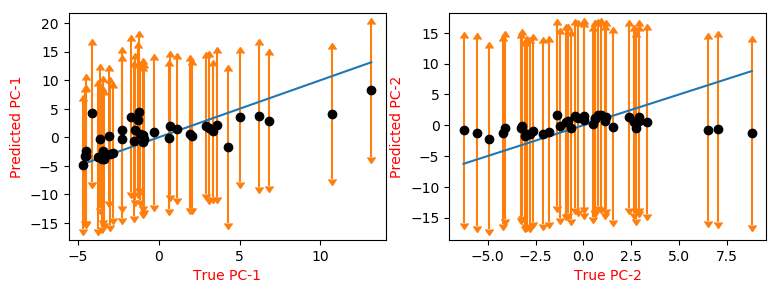

In [7]:
# Defines the number of samples used for training and testing the gpr model
split_size = 110
num_pc_analyzed = 2

from matplotlib.pyplot import figure
figure(figsize=(9, 3), dpi=100)

""" Looping through the first two principal components"""

for j in range(num_pc_analyzed):
    """ Training data """
    # Converting numpy array to tensor
    train_x = torch.from_numpy(train_x_numpy[:split_size,:])
    # Converting the output training data to numpy array
    train_y = torch.from_numpy(principalComponents[:split_size,j])
    """ Testing data """
    test_x = torch.from_numpy(train_x_numpy[split_size:num_samples,:])
    test_y = principalComponents[split_size:num_samples,j]
    # Defining models for GPR
    model = ExactGPModel(train_x, train_y, likelihood)
    """ Training the GPR model"""
    # this is for running the notebook in our testing framework
    import os
    smoke_test = ('CI' in os.environ)
    training_iter = 2 if smoke_test else 1000
    # Find optimal model hyperparameters
    model.train()
    likelihood.train()
    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters
    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f' % (
            i + 1, training_iter, loss.item(),

        ))
        optimizer.step()
    
    # Get into evaluation (predictive posterior) mode
    model.eval()
    likelihood.eval()
    # Test points are regularly spaced along [0,1]
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = likelihood(model(test_x))
        
    with torch.no_grad():
        # Calculating upper and lower bounds of model predictions
        lower, upper = observed_pred.confidence_region()
        # converting upper and lower bound prediction sto numpy array
        lower_numpy = lower.numpy()
        upper_numpy = upper.numpy()
        # Claculating mean prediction
        output_model_predictions = observed_pred.mean.numpy()
        # fetching actual output data
        original_output = test_y
        
    # Calculating total error in predictions 
    error_prediction = np.subtract(upper_numpy, lower_numpy)
    # Discretizing coordinate system for updating the parietal_plots
    x_par = np.linspace(np.amin(original_output),np.amax(original_output), num = 100)
    # Plotting the parietal line y = x
    plt.subplot(1,2,j+1)
    plt.plot(x_par, x_par)
    # Plotting the output predictions against known output value
    plt.plot(original_output, output_model_predictions, 'o', color='black')
    # Plotting the errorbars
    plt.errorbar(original_output, output_model_predictions,
                yerr = error_prediction, lolims = lower_numpy, uplims = upper_numpy, linestyle = "None")
    plt.xlabel("True PC-" + str(j+1),color="red")
    plt.ylabel("Predicted PC-" + str(j+1),color="red")
        
plt.show()            